# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [4]:
#To solve PIL failure issue
!pip install -v Pillow==5.4.1
!pip install Pillow --upgrade==5.4.1


Cleaning up...
You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

--upgrade option does not take a value


In [5]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


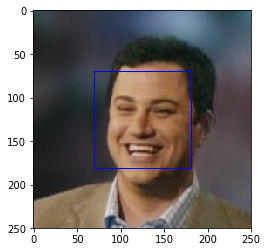

In [7]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[23])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),1)
    
# convert BGR image to RGB for plotting ie. color space transformation
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [8]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)<br />

<font color=#0099ff>98% of human images were detected with face.<br />
17% of dog images were detected with face.<br />
Obviouly, this detect is better for dectecting human face since it was trained by human images.</font>

In [6]:
from tqdm import tqdm


human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

human_detected = 0
for human in tqdm(human_files_short):
    if face_detector(human):
        human_detected += 1
        
dog_detected = 0
for dog in tqdm(dog_files_short):
    if face_detector(dog):
        dog_detected += 1
        
print('# of human images with face: ',human_detected)
print('# of dog images with face: ',dog_detected)


## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.


100%|██████████| 100/100 [00:27<00:00,  7.38it/s]

# of human images with face:  98
# of dog images with face:  17


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [7]:
# ### (Optional) 
# ### TODO: Test performance of anotherface detection algorithm.
# ### Feel free to use as many code cells as needed.


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [9]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:09<00:00, 59595868.92it/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [10]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    img = cv2.imread(img_path)
    img_transform = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((224,224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    img = img_transform(img).unsqueeze(0)

    if use_cuda:
        img= img.cuda()
    output = VGG16(img)
    _, pred =  torch.max(output, 1)
    
      
    return pred

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [11]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    index = VGG16_predict(img_path)
    if index >= 151 and index <=268:
        return True
    return False

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


<font color=#0099ff>0% of human images were detected with dogs.<br />
95% of dog images were detected with dogs.<br />
VGG16 has good performance in detecting dogs, and the accuracy of detecting dog will increase from 65% to 95% by adding normalization in image transaformation part</font>

In [11]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

human_detected = 0
for human in tqdm(human_files_short):
    if dog_detector(human):
        human_detected += 1
        
dog_detected = 0
for dog in tqdm(dog_files_short):
    if dog_detector(dog):
        dog_detected += 1
        
print('# of human images with dog: ',human_detected)
print('# of dog images with dog: ',dog_detected)


## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.


100%|██████████| 100/100 [00:04<00:00, 22.31it/s]

# of human images with dog:  0
# of dog images with dog:  95


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [12]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

import torch
import torchvision.models as models

# define ResNet152 model
resnet152 = models.resnet152(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    resnet152 = resnet152.cuda()

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.torch/models/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:03<00:00, 78976224.52it/s]


In [13]:
from PIL import Image
import torchvision.transforms as transforms

def resnet152_predict(img_path):
   
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    img = cv2.imread(img_path)
    img_transform = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((224,224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    img = img_transform(img).unsqueeze(0)

    if use_cuda:
        img= img.cuda()
    output = resnet152(img)
    _, pred =  torch.max(output, 1)
    
      
    return pred

In [14]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector2(img_path):
    ## TODO: Complete the function.
    index = resnet152_predict(img_path)
    if index >= 151 and index <=268:
        return True
    return False

In [15]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

human_detected = 0
for human in tqdm(human_files_short):
    if dog_detector2(human):
        human_detected += 1
        
dog_detected = 0
for dog in tqdm(dog_files_short):
    if dog_detector2(dog):
        dog_detected += 1
        
print('# of human images with dog: ',human_detected)
print('# of dog images with dog: ',dog_detected)


## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.


100%|██████████| 100/100 [00:07<00:00, 16.08it/s]

# of human images with dog:  0
# of dog images with dog:  0


I used ResNet for dog dection, however it can not distinguish dog this way, unfortunately.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [12]:
from torchvision import datasets
import torchvision
from PIL import ImageFile
import torchvision.transforms as transforms
import torch

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

data_transforms_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomApply([
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomRotation(20)
    ], p = 0.8), 
    torchvision.transforms.Resize(256),
    torchvision.transforms.RandomCrop(224),
    torchvision.transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

data_transforms_valid = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.RandomCrop(224),
    torchvision.transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

batch_size = 32
shuffle = True
threads = 0

train_data = torchvision.datasets.ImageFolder("/data/dog_images/train", data_transforms_train)
valid_data = torchvision.datasets.ImageFolder("/data/dog_images/valid", data_transforms_valid)
test_data = torchvision.datasets.ImageFolder("/data/dog_images/test", data_transforms_valid)

loaders_scratch = dict()
loaders_scratch['train'] = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
                                               shuffle = shuffle, num_workers = threads)
loaders_scratch['valid'] = torch.utils.data.DataLoader(valid_data, batch_size = batch_size, 
                                               shuffle = shuffle, num_workers = threads)
loaders_scratch['test'] = torch.utils.data.DataLoader(test_data, batch_size = batch_size, 
                                               shuffle = shuffle, num_workers = threads)


ImageFile.LOAD_TRUNCATED_IMAGES = True

In [13]:
loaders_scratch

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f71a6d38ef0>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7f71a6d24668>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f71a6d247b8>}

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
<font color=#0099ff><br />
1.I apply random cropping to resize my images since. I choose 224 as my size because it can cut off some irrelevant imformtion for training.The bigger the input, the more parameters your network will have to handle. More parameters will need more computing power. Then more data is needed for training, or under-fitting problem may occur. In my opinion, random crop and flip are both equal to increaing the trainning set.<br /><br />
2.Yes, I do retation and flip with certain possibility to enhance the ability of generalization.</font>

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [18]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        
        self.conv1 = nn.Conv2d(3, 64, 7, stride=2, padding=3)
        #Input: 224x224x3 Output: 112x112x64      
        self.maxpool_1 = nn.MaxPool2d(3, 2)
        #Input: 112x112x64 Output: 56x56x64      
        self.conv2 = nn.Conv2d(64, 128, 1)
        #Input: 56x56x64 Output: 56x56x96 linear conbination of features 
        self.conv3 = nn.Conv2d(128, 192, 3, padding=1)
        #Input: 56x56x96 Output: 56x56x192
        self.maxpool_2 = nn.MaxPool2d(3, 2)
        #Input: 56x56x192 Output: 27x27x192
        self.conv4 = nn.Conv2d(192, 384, 3, padding=1)
        #Input: 27x27x192 Output: 27x27x384
        self.maxpool_3 = nn.MaxPool2d(3, 2)
        #Input: 27x27x384 Output: 13x13x384
        self.conv5 = nn.Conv2d(384, 256, 3, padding=1)

        self.fc3 = nn.Linear(256, 133)
        
        self.GlobalAveragePool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        ## Define forward behavior of convolution layers and pooling layers 
        x = self.maxpool_1(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.maxpool_2(F.relu(self.conv3(x)))
        x = self.maxpool_3(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = self.GlobalAveragePool(x)
        
        
        # flatten image input
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc3(x)
       
        return x
        

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

<font color=#0099ff><br />
At first I had no idea about how to design my own architecture, so I searched the paper of AlexNext, VGG, and GoogLeNet. I discarded the 11x11 convolutional kernel in AlexNet since it will slow down the calculation a lot, and I changed to 5x5 only. After that, I applied 1x1 convolutional kernel which is the concept from GoogLeNet to blend the information in different channels and increase the dimension. Then, I did the 3x3 convolution and pooling to decrease image size for many times, and I ended my feature extractor with global average pooling layer. I removed most of the MLP layers since it would slow down the calculation and sometimes lead to overfit, also, teh Global Average Pooling layer can have the same function as MLP here. Therefore, only one MLP as final layer was used. Dropout layers were put before dense layer to prevent overfit.
</font>

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [22]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr= 0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [20]:
model_scratch.load_state_dict(torch.load('model_scratch.pt128'))

In [23]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion_scratch(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion_scratch(output, target)           
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
        
            
    # return trained model
    return model


# train the model
n_epochs = 50
model_scratch = train(n_epochs, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt128')



Epoch: 1 	Training Loss: 2.441560 	Validation Loss: 2.862631
Epoch: 2 	Training Loss: 2.320518 	Validation Loss: 2.814318
Epoch: 3 	Training Loss: 2.326202 	Validation Loss: 2.717717
Epoch: 4 	Training Loss: 2.243518 	Validation Loss: 2.797328
Epoch: 5 	Training Loss: 2.188729 	Validation Loss: 2.781240
Epoch: 6 	Training Loss: 2.173714 	Validation Loss: 2.758035
Epoch: 7 	Training Loss: 2.140508 	Validation Loss: 2.777526
Epoch: 8 	Training Loss: 2.125968 	Validation Loss: 2.821622
Epoch: 9 	Training Loss: 2.035218 	Validation Loss: 2.642794
Epoch: 10 	Training Loss: 2.012022 	Validation Loss: 2.830211
Epoch: 11 	Training Loss: 1.964348 	Validation Loss: 2.740879
Epoch: 12 	Training Loss: 1.928331 	Validation Loss: 2.711204
Epoch: 13 	Training Loss: 1.879460 	Validation Loss: 2.666196
Epoch: 14 	Training Loss: 1.874929 	Validation Loss: 2.657883
Epoch: 15 	Training Loss: 1.842947 	Validation Loss: 2.857997
Epoch: 16 	Training Loss: 1.805955 	Validation Loss: 2.688023
Epoch: 17 	Traini

KeyboardInterrupt: 

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [14]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders_scratch['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))



In [24]:
model_scratch.load_state_dict(torch.load('model_scratch.pt128'))
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.595214


Test Accuracy: 41% (348/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [15]:
loaders_transfer = loaders_scratch.copy()

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [16]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.resnet101(pretrained = True)
model_transfer.fc = nn.Linear(2048, 133)
# check if CUDA is available
use_cuda = torch.cuda.is_available()
if use_cuda:
    model_transfer = model_transfer.cuda()


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.torch/models/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:02<00:00, 74082181.16it/s]


__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
<font color=#0099ff><br />
Yes, there is a list in PyTorch documentation with different models. At first I choose Inception V3 since its structure remove lots of MLP in the classifier to speed up the calculation. However, the input image should be resize to 299x299 which is not suitable for me to compare with my home-made model which input is 224x224. Therefore I choose ResNet-101, the groundbreaking model, and I think ResNet-152 can be too heavy for this classification because our datasets are not as complicate as ImageNet. I can save my time and GPU resouce. 
</font>


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [17]:
criterion_transfer = torch.nn.CrossEntropyLoss()
optimizer_transfer = torch.optim.SGD(model_transfer.fc.parameters(),lr = 0.001, momentum = 0.995)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [ ]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion_transfer(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion_transfer(output, target)           
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
        
            
    # return trained model
    return model




# train the model
n_epochs = 20
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.551105 	Validation Loss: 0.750789
Epoch: 2 	Training Loss: 0.661767 	Validation Loss: 0.563171
Epoch: 3 	Training Loss: 0.508661 	Validation Loss: 0.489247
Epoch: 4 	Training Loss: 0.422062 	Validation Loss: 0.609188
Epoch: 5 	Training Loss: 0.389143 	Validation Loss: 0.564452
Epoch: 6 	Training Loss: 0.383478 	Validation Loss: 0.492267
Epoch: 7 	Training Loss: 0.335624 	Validation Loss: 0.570839
Epoch: 8 	Training Loss: 0.294068 	Validation Loss: 0.491736
Epoch: 9 	Training Loss: 0.259600 	Validation Loss: 0.614863
Epoch: 10 	Training Loss: 0.276477 	Validation Loss: 0.608457
Epoch: 11 	Training Loss: 0.268009 	Validation Loss: 0.496431
Epoch: 12 	Training Loss: 0.218084 	Validation Loss: 0.478299
Epoch: 13 	Training Loss: 0.228920 	Validation Loss: 0.492969
Epoch: 14 	Training Loss: 0.213558 	Validation Loss: 0.520084
Epoch: 15 	Training Loss: 0.228555 	Validation Loss: 0.529452
Epoch: 16 	Training Loss: 0.223494 	Validation Loss: 0.588212
Epoch: 17 	Traini

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [18]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.736612


Test Accuracy: 85% (718/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [34]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
import cv2  
from PIL import Image    
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    img = Image.open(img_path)
    global model_transfer
    data_transforms_input = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])             
    img = data_transforms_input(img).unsqueeze(0)
    if use_cuda:
        img = img.cuda()
        model_transfer = model_transfer.cuda()
    breed_idx = model_transfer(img).argmax()



    #print(output)
    return class_names[breed_idx] 

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [35]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
from PIL import Image
def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    if face_detector:
        print("Hey! You are human, but you look like a ... {}".format(predict_breed_transfer(img_path)))
    elif dog_detector:
        print("Hey cute doggie! You look like a ... {}".format(predict_breed_transfer(img_path)))
    else:
        print("Interpretation Fail !! :((")
    
    


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
<font color=#0099ff><br />
No, It is worse than I expected because the main problem is it can't classify human and dog properly, though it can classify dog into different breed with decent accuracy. Here are points worth improving in the future:
1. We can apply transfer learning ,adn retrain with both human and dog images. Also it's final layer should be to neuron only (human and dog). Thus, we can increase the accuracy of classifying human and dog in the beginning.
2. F1 score and confusion matrix can be used to evaule the performance of the dog and human detector.
3. For my home-made CNN model, we can train more epochs to further decrease the loss (as my observation, the validation still has some room the drop.)
4. Batch normalization can be added between layers in my home-made model to avoid overfitting and make it more gerneral.
5. 2 Step gradient descent may be a good choice to speed up training. We can use Adam first and then SGD for further accuracy improvement.
6. For the transfer, we can lower the learning with more epochs to further improve its accuracy.
</font>

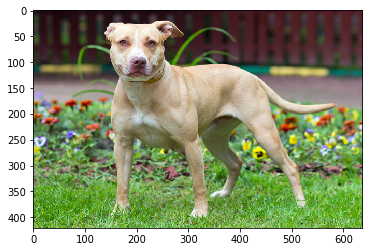

Hey! You are human, but you look like a ... American staffordshire terrier


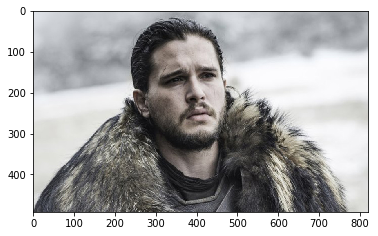

Hey! You are human, but you look like a ... Irish wolfhound


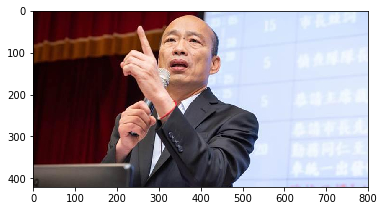

Hey! You are human, but you look like a ... Cardigan welsh corgi


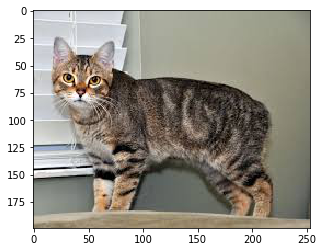

Hey! You are human, but you look like a ... Boston terrier


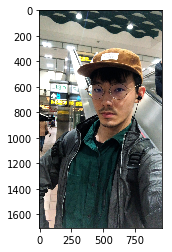

Hey! You are human, but you look like a ... Glen of imaal terrier


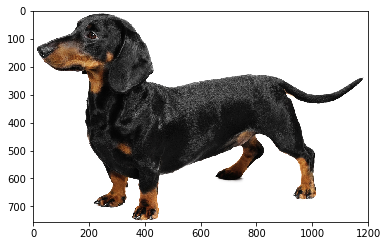

Hey! You are human, but you look like a ... Black and tan coonhound


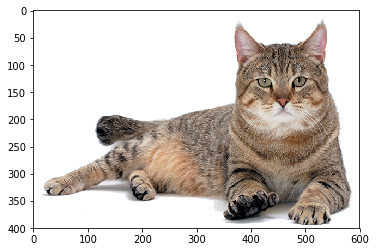

Hey! You are human, but you look like a ... Australian cattle dog


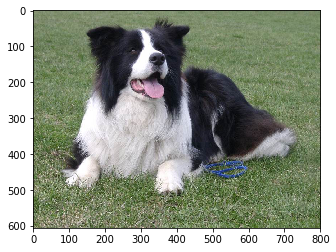

Hey! You are human, but you look like a ... Border collie


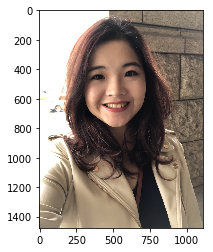

Hey! You are human, but you look like a ... Yorkshire terrier


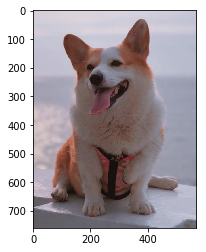

Hey! You are human, but you look like a ... Cardigan welsh corgi


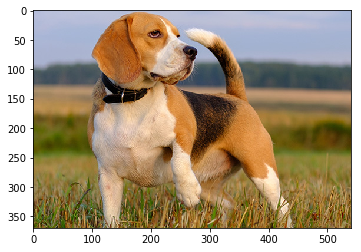

Hey! You are human, but you look like a ... Beagle


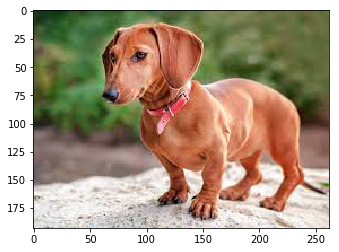

Hey! You are human, but you look like a ... Dachshund


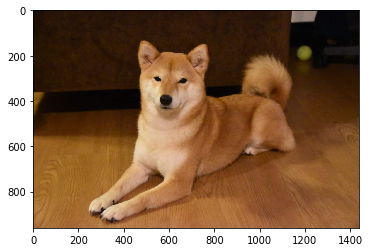

Hey! You are human, but you look like a ... Akita


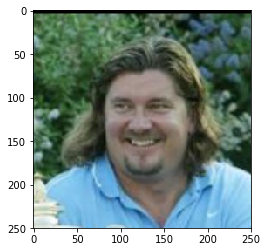

Hey! You are human, but you look like a ... Australian shepherd


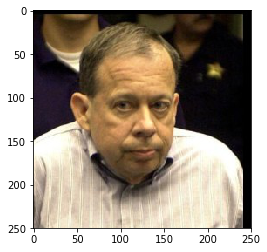

Hey! You are human, but you look like a ... American staffordshire terrier


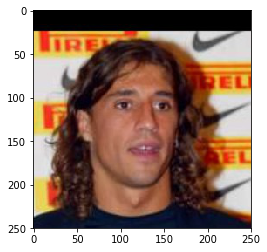

Hey! You are human, but you look like a ... Doberman pinscher


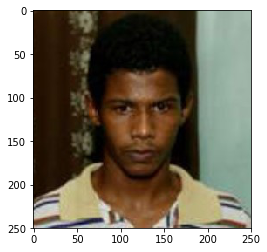

Hey! You are human, but you look like a ... Doberman pinscher


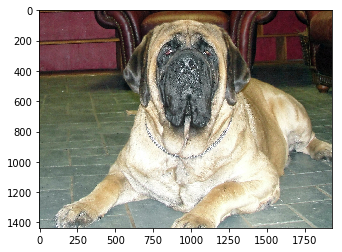

Hey! You are human, but you look like a ... Mastiff


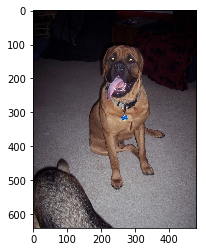

Hey! You are human, but you look like a ... Mastiff


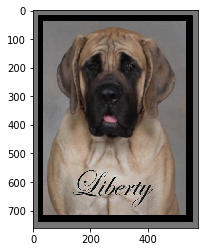

Hey! You are human, but you look like a ... Mastiff


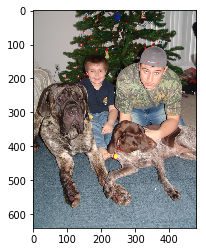

Hey! You are human, but you look like a ... Mastiff


In [42]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

mypictures = np.array(glob("/home/workspace/dog_project/MyPictures/*.jpg"))

## suggested code, below

for file in mypictures:
    run_app(file)
for file in np.hstack((human_files[16:20], dog_files[36:40])):
    run_app(file)